In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1593: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']',''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)
    

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [3]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [4]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_inputb_raw['entity']=df_inputb_raw['DEVICE_ID']
df_inputb_raw['timestamp']=df_inputb_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_inputb_raw = df_inputb_raw.sort_values(by='timestamp')
df_inputb_raw = df_inputb_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_inputb_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_inputb_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_inputb_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_inputb_raw)
#l2norm(df_inputb, 'accel_power', 'ACCEL_POWER')

df_inputb = df_inputb_raw.filter(listAttr, axis=1)
df_inputb.head(5)

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  1.732051          1.0   
             2020-01-01 00:07:12.739    3.786815  1.732051          1.0   
             2020-01-01 00:12:12.769    3.653347  1.732051          1.0   
             2020-01-01 00:17:12.806    3.673086  1.732051          1.0   
             2020-01-01 00:22:13.071    3.754269  1.732051          1.0   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

In [5]:
EngineLogging.configure_console_logging(logging.INFO)

df_inputb2 = df_inputb.loc[['04714B604101']]
df_inputb2.reset_index(level=[0], inplace=True)

df_inputb2


,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
timestamp,,,,,,,,,
2020-01-01 00:02:12.713,04714B604101,3.718562,1.732051,1.0,2.3650,2.3388,2.3410,2.3578,2.5272
2020-01-01 00:07:12.739,04714B604101,3.786815,1.732051,1.0,2.5250,2.3846,2.3978,2.3980,2.5762
2020-01-01 00:12:12.769,04714B604101,3.653347,1.732051,1.0,2.5186,2.3766,2.3606,2.4578,2.5150
2020-01-01 00:17:12.806,04714B604101,3.673086,1.732051,1.0,2.4960,2.3822,2.3832,2.4854,2.3844
2020-01-01 00:22:13.071,04714B604101,3.754269,1.732051,1.0,2.5404,2.3874,2.3896,2.4240,2.4112
...,...,...,...,...,...,...,...,...,...
2020-01-31 11:36:16.066,04714B604101,3.670139,1.732051,1.0,2.2880,2.2846,2.2898,2.2878,2.2852
2020-01-31 11:41:15.841,04714B604101,3.893611,1.732051,1.0,2.2808,2.2876,2.2852,2.2712,2.2704
2020-01-31 11:46:16.049,04714B604101,3.660626,1.732051,1.0,2.2820,2.2724,2.2700,2.2682,2.2706


#### Try out supervised methods

* Run gradient boosting


In [6]:
# Now run gradient boosting - using lightGBM

X_train = df_input[['accel_speed','accel_power_0','accel_power_1','accel_power_2',
                    'accel_power_3','accel_power_4']].to_numpy()
y_train = df_input['vibrations'].to_numpy()

In [7]:
import lightgbm
gbr = lightgbm.LGBMRegressor(n_estimators=4000, learning_rate=0.000001, num_leaves=40,
                           max_depth=20, random_state=42, loss='huber').fit(X_train, y_train)


In [8]:
pred_good = gbr.predict(X_train)
rmse = metrics.mean_squared_error(y_train, pred_good)
gbscoreg = np.abs(pred_good - y_train)
print (rmse)

0.001106535670881264


In [9]:
X_bad = df_inputb[['accel_speed','accel_power_0','accel_power_1','accel_power_2',
                   'accel_power_3','accel_power_4']].to_numpy()
y_bad = df_inputb['vibrations'].to_numpy()
pred_bad = gbr.predict(X_bad)
#pred_bad = [3.714736 for i in pred_bad]
rmseb = metrics.mean_squared_error(y_bad, pred_bad)
gbscore = np.abs(pred_bad - y_bad)
print (rmseb)

0.009797515412096496


Text(0.5, 1.0, 'Vibration Forecast - bad prediction')

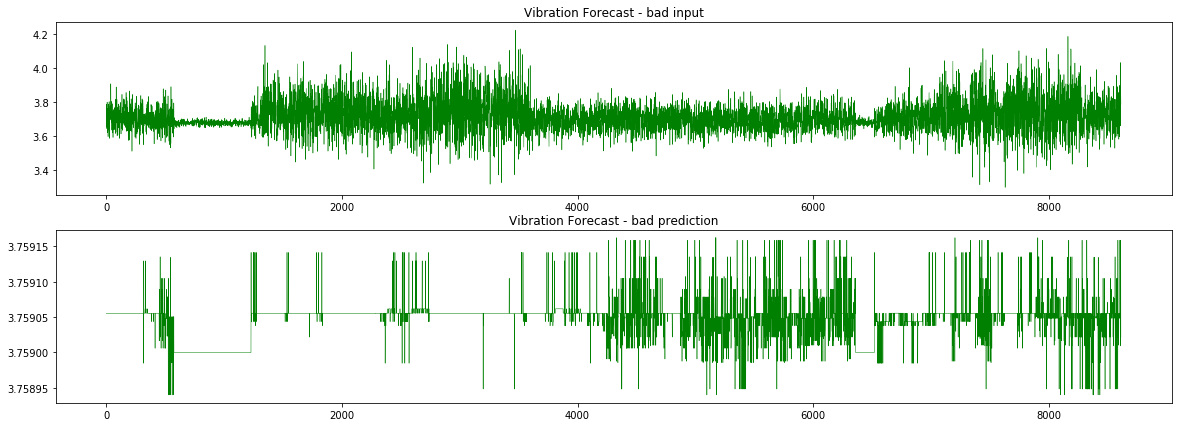

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
ax[0].plot(y_bad, lw=0.5, color='green')
ax[0].set_title('Vibration Forecast - bad input')
ax[1].plot(pred_bad, lw=0.5, color='green')
ax[1].set_title('Vibration Forecast - bad prediction')

Text(0.5, 1.0, 'Good Case - no anomalous deviation from prediction')

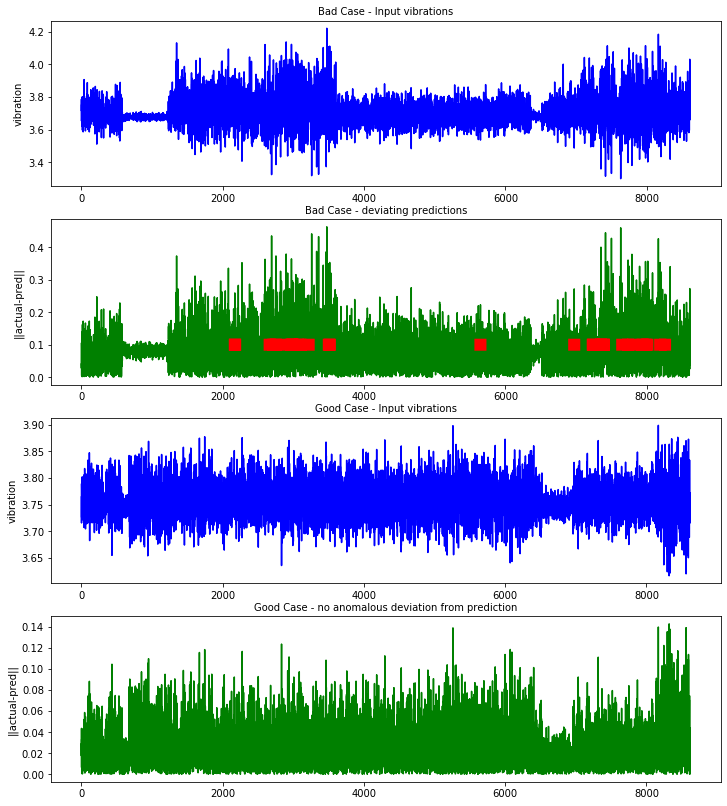

In [11]:
separator = 0.2
anomalygb = gbscore.copy() #(gbscore > separator) # * (separator + 0.1)
anomalygb[anomalygb <= separator] = 0
anomalygb[anomalygb > separator] = separator/2
anomalygb[anomalygb == 0] = np.nan
anomalygg = gbscoreg.copy()
anomalygg[anomalygg <= separator] = 0
anomalygg[anomalygg > separator] = separator/2
anomalygg[anomalygg == 0] = np.nan

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,14)) 
ax1.plot(y_bad, color='blue')
ax1.set_title('Bad Case - Input vibrations', fontsize=10)
ax1.set_ylabel('vibration')
ax2.plot(gbscore, color='green')
ax2.plot(anomalygb, color='red', lw=12, zorder=10)
ax2.set_ylabel('||actual-pred||')
ax2.set_title('Bad Case - deviating predictions', fontsize=10)
ax3.plot(y_train, color='blue')
ax3.set_ylabel('vibration')
ax3.set_title('Good Case - Input vibrations', fontsize=10)
ax4.plot(gbscoreg, color='green')
ax4.plot(anomalygg, color='red', lw=12, zorder=10)
ax4.set_ylabel('||actual-pred||')
ax4.set_title('Good Case - no anomalous deviation from prediction', fontsize=10)



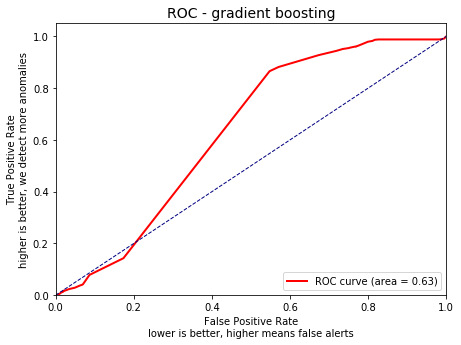

In [20]:
# ROC curve FFT
from sklearn.metrics import roc_curve, auc, roc_auc_score

# before anomaly "negatives"
before_anomaly1 = dt.datetime(2020,1,7,0,0,0)  # before anomaly "negatives"
after_anomaly1 = dt.datetime(2020,1,14,0,0,0)  
before_anomaly2 = dt.datetime(2020,1,27,0,0,0) 
after_anomaly2 = dt.datetime(2020,1,31,0,0,0)

df_inputb2.loc[df_inputb2.index < before_anomaly1,'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly1) &
           (df_inputb2.index < after_anomaly1),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly1) &
           (df_inputb2.index < before_anomaly2),'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly2) &
           (df_inputb2.index < after_anomaly2),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly2),'actual'] = 0

yyy_test = df_inputb2['actual'].values
fprFg, tprFg, _ = roc_curve(yyy_test, pred_bad)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - gradient boosting', fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [15]:
df_test = pd.DataFrame()
df_test['y_bad']  = y_bad
df_test['y_pred'] = pred_bad
df_test['gbscore'] = gbscore
df_test['actual'] = df_inputb2['actual'].values

df_test.describe()
#df_inputb2.actual.unique()
#df_test

,y_bad,y_pred,gbscore,actual
count,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,3.759048,0.080022,0.367352
std,0.088517,0.000026,0.058262,0.482111
min,3.299344,3.758940,0.000022,0.000000
25%,3.664859,3.759048,0.037035,0.000000
50%,3.701923,3.759055,0.072573,0.000000
75%,3.758416,3.759055,0.106176,1.000000
max,4.221860,3.759162,0.462804,1.000000


#### Results

Gradient boosting appears to do much better

- Much shorter training time compared to the NASA model
- Prediction

To be investigated further
    


In [16]:
from sklearn.metrics import r2_score

'''
Coefficent of determinatoin: the proportion of the variance in the dependent variable 
that is predictable from the independent variable(s). It provides a measure of how well 
observed outcomes are replicated by the model, based on the proportion of total variation 
of outcomes explained by the model
Best posible score = 1.0
Values of r2 outside 0-1: model fits data worse than a horizontal hyperplane
'''

print('R_sq/Test Variance score:' + str(r2_score(y_bad, pred_bad)))

R_sq/Test Variance score:-0.25058676111247435


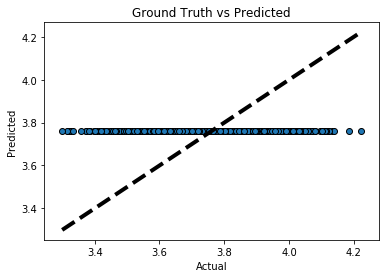

In [17]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_bad, pred_bad, edgecolors=(0, 0, 0))
ax.plot([y_bad.min(), y_bad.max()], [y_bad.min(), y_bad.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()